In [1]:
import sys
sys.path.append('..')
from data_utils import *

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
from transformer import *
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using CUDA

### Plotting Things and Sorting them

In [19]:
cd ..

/sdf/home/c/carsmith/flash_reconstruction/flash_detection


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [21]:
data = np.load('1photon_study.npy', allow_pickle=True)
print(type(data))
print(data)

<class 'numpy.ndarray'>


KeyboardInterrupt: 

In [2]:
# Loading in data
load_wfs = np.load('/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delay_200ks/2_8.npy', allow_pickle=True) # array of shape (2519, 5, 250, 250)
dataset = WaveformDataset(load_wfs.item())

g = torch.Generator()
g.manual_seed(seed)

# Splitting data
val_ratio = 0.1
test_ratio = 0.0
total_size = len(dataset)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)
train_size = total_size - val_size - test_size
print(f"split sizes: {train_size, val_size, test_size}")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=g)

batch_size = 25

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
        hit_times: Tensor of shape (?) with a list of hit times per sample
    """
    waveforms, arrival_times, hit_times, photon_bins, photon_list = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0)

     # Normalizing waveforms
    waveforms = (waveforms - waveforms.mean(dim=1, keepdim=True)) / (waveforms.std(dim=1, keepdim=True) + 1e-8)
    waveforms = waveforms.unsqueeze(1)  # add channel dimension [B,1,L]

    # for binary classification
    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension
    photon_bins = torch.stack(photon_bins, dim=0)
    photon_bins = photon_bins.unsqueeze(1)

    # for regression, just use hit times
    hit_times = [item[2] for item in batch]
    hit_times = torch.tensor(hit_times)
    photon_list = [item[4] for item in batch]
    photon_list = torch.tensor(photon_list)
    
    return waveforms, arrival_times, hit_times, photon_bins, photon_list
    

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

split sizes: (180000, 20000, 0)


/lscratch/carsmith/tmp/ipykernel_1290680/1004424815.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  hit_times = torch.tensor(hit_times)


hit_times: torch.Size([25, 8])
torch.Size([25, 1, 8000])
torch.Size([25, 1, 8000])


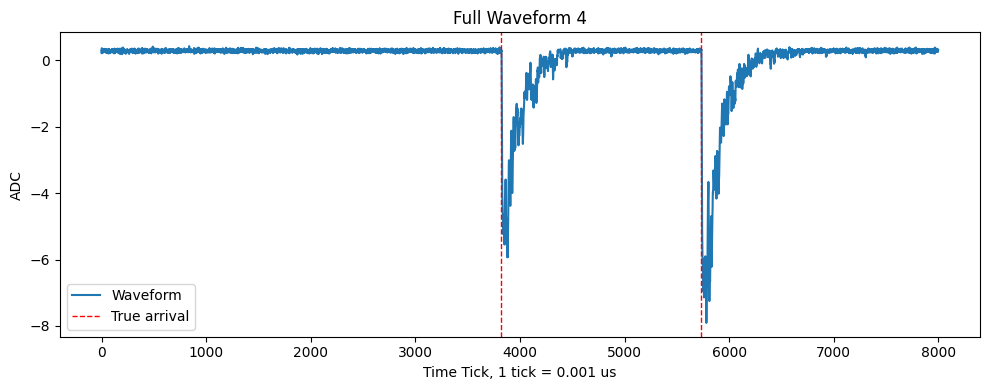

In [3]:
# Inspecting data
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(train_loader))
print(f"hit_times: {hit_times.shape}")
print(waveforms.shape)
print(arrival_times.shape)
ticks = np.arange(waveforms[0].shape[1])

waveform_id = 4
wf = waveforms[waveform_id]

ticks = torch.arange(wf.shape[-1])  # assume ticks = [0, 1, ..., length-1]
wf = wf.squeeze(0)  # shape: [length]

plt.figure(figsize = (10, 4))
plt.plot(ticks, wf, alpha=1, label='Waveform')

# FOR MULTIPLE HITS!
for j, t in enumerate(hit_times[waveform_id]):
    if t < 0:
        pass
    else:
        plt.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label='True arrival' if j == 0 else ""
        )
        
plt.title(f"Full Waveform {waveform_id}")
plt.xlabel(f"Time Tick, 1 tick = 0.001 us")
plt.ylabel("ADC")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from conformer import *
from transformer import *
from utils import *
import torch.optim as optim
import wandb

epochs = 2
device = 'cuda'

# try tracking with wandb
logger = wandb.init(
    project="conformer",
    name="5M_test",
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": 1e-4,
    }
)

model = ConformerModel(d_model=256, num_heads=8, num_layers=4)
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
wandb.watch(model, log="all", log_freq=100)

criterion = torch.nn.BCEWithLogitsLoss() # combines sigmoid + loss
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

mode = 'mined_bce'

# results = train_model_2(model, train_loader, val_loader, scheduler, optimizer, device, epochs, mode, logger)
# wandb.finish()

### Characterizing the Dataset

In [ ]:
epoch = 0
epochs = 1
train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False, position=0, disable=True)
device = 'cuda'
# hash tables of a sort
photon_bins = torch.zeros((990,))
interval_bins = torch.zeros((8000,))

for i, (data, target, hit_times, photon_target, photon_list) in enumerate(train_progress):
    data, target, photon_target = data.to(device), target.to(device), photon_target.to(device) # both [B, 1, 8000]
    
    # get # photons per flash
    nonzero_mask = photon_list != 0
    nonzero_photons = photon_list[nonzero_mask]
    photon_bins[nonzero_photons - 11] += 1 # 0-indexed

    # get interval lengths
    for b in range(hit_times.shape[0]): # hit times has absolute time stamps of events
        mask = hit_times[b] != -1
        sample_times = torch.sort(hit_times[b][mask]).values # keep batch indices indices
        diffs = torch.diff(sample_times)
        diffs = diffs.long()
        bincounts = torch.bincount(diffs, minlength=interval_bins.shape[0])
        interval_bins += bincounts
    
# print(interval_bins[:200])
plt.figure(figsize=(10, 4))
plt.plot(interval_bins.cpu().numpy()[:600])  # First 200 bins
plt.xlabel("Interval Length")
plt.ylabel("Count")
plt.title("Interval Distribution")
plt.grid(True)
plt.show()

In [119]:
photon_bins = torch.zeros((990,))
interval_bins = torch.zeros((8000,))

diffs_list = []

for i, (data, target, hit_times, photon_target, photon_list) in enumerate(train_progress):
    data, target, photon_target = data.to(device), target.to(device), photon_target.to(device)  # [B, 1, 8000]
    
    # ---- Photon counts ----
    nonzero_mask = photon_list != 0
    nonzero_photons = photon_list[nonzero_mask]
    photon_bins[nonzero_photons - 11] += 1  # shift into [0..979] range

    # ---- Interval lengths ----
    for b in range(hit_times.shape[0]):
        mask = hit_times[b] != -1
        sample_times = torch.sort(hit_times[b][mask]).values  # valid photon times
        if sample_times.numel() > 1:  # need at least 2 to get a diff
            diffs = torch.diff(sample_times)
            diffs = diffs.long()
            diffs_list.append(diffs)

all_diffs = torch.cat(diffs_list)

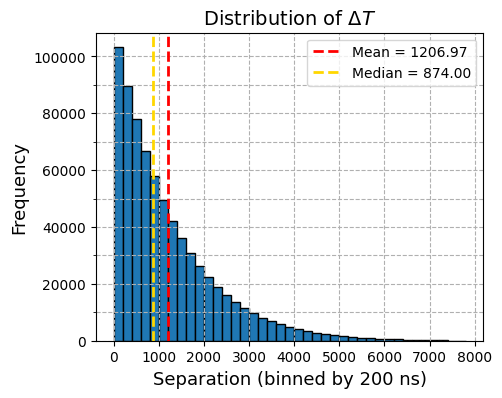

In [164]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Get unique values and counts
values, counts = torch.unique(all_diffs, return_counts=True)

# Convert to numpy
arr = all_diffs.cpu().numpy()

# Compute statistics
mean_val = arr.mean()
median_val = np.median(arr)

# Histogram
plt.figure(figsize=(5, 4))
plt.hist(arr, bins=range(0, arr.max() + 200, 200), edgecolor='black', label='_nolegend_')

plt.xlabel("Separation (binned by 200 ns)", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.title("Distribution of $\Delta T$", fontsize=14)

# Add grid with more ticks on y axis
plt.grid(which='both', linestyle='--')
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(500))   # adjust spacing as needed
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(10000))   # denser gridlines

# Add legend with mean & median
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, color='gold', linestyle='--', linewidth=2, label=f"Median = {median_val:.2f}")
plt.legend()

plt.show()


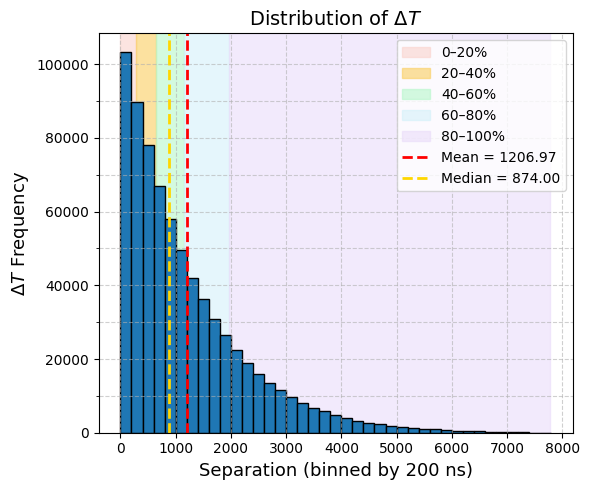

In [179]:
# Get unique values and counts
values, counts = torch.unique(all_diffs, return_counts=True)

# Convert to numpy
arr = all_diffs.cpu().numpy()

# Compute statistics
mean_val = arr.mean()
median_val = np.median(arr)

# Define quantile bins (e.g., quintiles → 20% increments)
quantiles = np.percentile(arr, [0, 20, 40, 60, 80, 100])

plt.figure(figsize=(6, 5))

# Background shading for density ranges
colors = ['#fad3cd', '#face5f', '#b7f7cb', '#d4f1fa', '#eadcfa']  # light → dark
for i in range(len(quantiles) - 1):
    plt.axvspan(quantiles[i], quantiles[i+1], color=colors[i], alpha=0.6,
                label=f"{i*20}–{(i+1)*20}%")

# Histogram
plt.hist(arr, bins=range(0, arr.max() + 200, 200), edgecolor='black', label='_nolegend_')

# Axis labels & title
plt.xlabel("Separation (binned by 200 ns)", fontsize=13)
plt.ylabel("$\Delta T$ Frequency", fontsize=13)
plt.title("Distribution of $\Delta T$", fontsize=14)

# Add grid with denser ticks
plt.grid(which='both', linestyle='--', alpha=0.6)
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(10000))  # example density

# Vertical lines for mean & median
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, color='gold', linestyle='--', linewidth=2, label=f"Median = {median_val:.2f}")

plt.legend()
plt.tight_layout()
plt.show()

In [144]:
print(all_diffs.float().mean().item())

1206.9705810546875


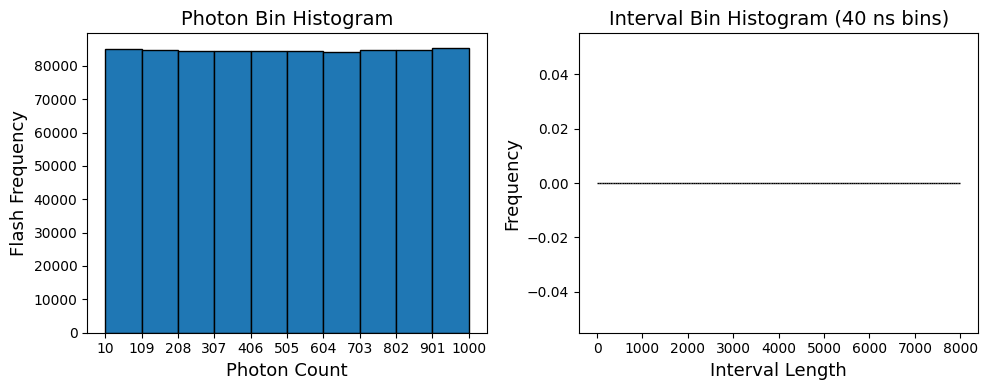

In [163]:
photon_bin_edges = np.linspace(0, 990, 11)
interval_bin_edges = np.linspace(0, 8000, 201, dtype=int)  # 200 bins

# Compute bin widths and centers
photon_widths = np.diff(photon_bin_edges)
photon_centers = photon_bin_edges[:-1] + photon_widths / 2

interval_widths = np.diff(interval_bin_edges)
interval_centers = interval_bin_edges[:-1] + interval_widths / 2

rebinned_photon = torch.tensor([photon_bins[i:i+int(photon_widths[0])].sum() for i in range(0, len(photon_bins), int(photon_widths[0]))])
rebinned_interval = torch.tensor([interval_bins[i:i+int(interval_widths[0])].sum() for i in range(0, len(interval_bins), int(interval_widths[0]))])
# Convert your torch tensors to numpy
photon_bins_np = photon_bins.cpu().numpy()
interval_bins_np = interval_bins.cpu().numpy()

# Plot
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(photon_centers, rebinned_photon, width=photon_widths, align='center', edgecolor='k')
plt.title("Photon Bin Histogram", fontsize=14)
plt.xticks(photon_bin_edges, labels=[int(t+10) for t in photon_bin_edges])
plt.xlabel("Photon Count", fontsize=13)
plt.ylabel("Flash Frequency", fontsize=13)

plt.subplot(1, 2, 2)
plt.bar(interval_centers, rebinned_interval, width=interval_widths, align='center', edgecolor='k')
plt.title(f"Interval Bin Histogram ({int(interval_widths[0])} ns bins)", fontsize=14)
plt.xlabel("Interval Length", fontsize=13)
plt.ylabel("Frequency", fontsize=13)

plt.tight_layout()
plt.show()

In [4]:
from conformer import *
device = 'cuda'
model = ConformerModel(tokens=None)
model.to(device)

ConformerModel(
  (tokenizer): Conv1d(1, 48, kernel_size=(100,), stride=(100,))
  (positional_encoding): PositionalEncoding()
  (conformer): Conformer(
    (conformer_layers): ModuleList(
      (0-1): 2 x ConformerLayer(
        (ffn1): _FeedForwardModule(
          (sequential): Sequential(
            (0): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=48, out_features=384, bias=True)
            (2): SiLU()
            (3): Dropout(p=0.0, inplace=False)
            (4): Linear(in_features=384, out_features=48, bias=True)
            (5): Dropout(p=0.0, inplace=False)
          )
        )
        (self_attn_layer_norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=48, out_features=48, bias=True)
        )
        (self_attn_dropout): Dropout(p=0.0, inplace=False)
        (conv_module): _ConvolutionModule(
          (layer_norm):

In [5]:
# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 194978


In [6]:
from model import *
model = UNet1D()
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 5687650


In [7]:
from transformer import *
model = TransformerModel()
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 2418178


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [15]:
from conformer import *
model = ConformerModel(d_model=256, num_heads=8, num_layers=4)
model.to(device)

ConformerModel(
  (tokenizer): MultiLevelTokenizer(
    (convs): ModuleList(
      (0): Conv1d(1, 256, kernel_size=(20,), stride=(1,), padding=(10,))
      (1): Conv1d(1, 256, kernel_size=(50,), stride=(1,), padding=(25,))
      (2): Conv1d(1, 256, kernel_size=(100,), stride=(1,), padding=(50,))
      (3): Conv1d(1, 256, kernel_size=(400,), stride=(1,), padding=(200,))
    )
    (pool): MaxPool1d(kernel_size=100, stride=100, padding=0, dilation=1, ceil_mode=False)
    (proj): Conv1d(1024, 256, kernel_size=(1,), stride=(1,))
  )
  (positional_encoding): PositionalEncoding()
  (conformer): Conformer(
    (conformer_layers): ModuleList(
      (0-1): 2 x ConformerLayer(
        (ffn1): _FeedForwardModule(
          (sequential): Sequential(
            (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=256, out_features=2048, bias=True)
            (2): SiLU()
            (3): Dropout(p=0.0, inplace=False)
            (4): Linear(in_features=2048

In [16]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 5683202


In [6]:
ls

1delayflash_reg.npy              merge_study_closed.npy
1delayflash_reg_130epochs.npy    multi_wf_test.npy
1delayflash_reg_70epochs.npy     new_transformer.ipynb
1delayflash_reg_80epochs.npy     performance_analysis/
CLEAN_regression_analysis.ipynb  photon_ratios_stats.npy
TESTING.ipynb                    photon_ratios_stats_130.npy
aaa.npy                          reg_study.ipynb
acc_1photon.npy                  regression_dev.ipynb
acc_2photon.npy                  sep_results.npy
acc_3photon.npy                  sep_results_100.npy
acc_5photon.npy                  simulating_data.ipynb
bin_precision.ipynb              single_amp_study.ipynb
compare_networks.ipynb           single_channel_unet.ipynb
data_gen.ipynb                   test.npy
data_gen2.ipynb                  testtest.npy
final_analysis.ipynb             train_conformer.ipynb
inspecting_data.ipynb            transformer_dev.ipynb
merge_study.ipynb                wandb/
merge_study.npy                  wandb_stealing.ipyn

### Performance Analysis Scratch

In [21]:
### Accumulating All Results
unet_results = np.load("performance_analysis/singleflash_eval_stats.npy", allow_pickle=True).item() #UNet, tr_215
c5M_t2M_results = np.load("performance_analysis/c5M_t2M_singlephot_stats.npy", allow_pickle=True).item() #conformer5M, transformer2M
c_195K_results = np.load("performance_analysis/conform_trans5x_singlephot_stats.npy", allow_pickle=True).item() #conformer195K
conv3_results = np.load("performance_analysis/conv3_delta_random_results.npy", allow_pickle=True).item()

all_results = {**unet_results, **c5M_t2M_results, **c_195K_results, **conv3_results}
model_names = list(all_results.keys())   # ['tr', 'unet']
model_names.remove('tr_160')
model_names.remove('conformer_30')
model_names.remove('transformer_5x_40')
print(model_names)

['tr_215', 'unet', 'conformer_5M', 'transformer_2M', 'conformer_50', 'conformer_v3']


In [22]:
delta_results = np.load("performance_analysis/deltastats_3trans_100k.npy", allow_pickle=True).item()
conformer_delta_results = np.load("performance_analysis/deltastats_conformers_trans5M_100k.npy", allow_pickle=True).item()
c5M_t2M_delta_results = np.load("performance_analysis/c5M_t2M_deltastats.npy", allow_pickle=True).item()
tr215_delta_results = np.load("performance_analysis/t215_deltastats.npy", allow_pickle=True).item()
less_overfit_conformer_results = np.load("performance_analysis/less_overfit_con_500deltas.npy", allow_pickle=True).item()
conv3_results = np.load("performance_analysis/conv3_e34_delta_random_results.npy", allow_pickle=True).item()
conv5_results = np.load("performance_analysis/conv5_pos_nomerge_delta_stats.npy", allow_pickle=True).item()


all_delta_results = {**delta_results, **tr215_delta_results, **conformer_delta_results, **c5M_t2M_delta_results, **less_overfit_conformer_results, **conv3_results, **conv5_results}

model_names = list(all_delta_results.keys())   # ['tr', 'unet']
print(model_names)
model_names.remove('tr_160')
model_names = list(all_delta_results.keys())   # ['tr', 'unet']

model_names.remove('tr_160')
model_names.remove('tr_180')
model_names.remove('conformer_30')
model_names.remove('transformer_5x_40')
model_names.remove('conformer_5M')
print(model_names)
print(all_delta_results['unet'].keys())

['tr_160', 'tr_180', 'unet', 'tr_215', 'conformer_30', 'conformer_50', 'transformer_5x_40', 'conformer_5M', 'transformer_2M', 'conformer_v2', 'conformer_v5_drop', 'conformer_v5', 'conformer_v3', 'conformer_v5_+']
['unet', 'tr_215', 'conformer_50', 'transformer_2M', 'conformer_v2', 'conformer_v5_drop', 'conformer_v5', 'conformer_v3', 'conformer_v5_+']
dict_keys(['bin_counts', 'reco_frac_flash1', 'reco_frac_flash2', 'merge_acc_flash1', 'merge_acc_flash2', 'merge_pure'])


In [5]:
delta_results = np.load("delta_t_50phot.npy", allow_pickle=True).item()
all_delta_results = delta_results

In [23]:
def aggregate_bins(delta_results, bin_size=1):
    """
    Aggregate results into coarser bins.
    bin_size = number of indices to merge (e.g. 10 for 10 ns bins).
    Uses mean over bins.
    """
    agg_results = {}

    for model, metrics in delta_results.items():
        agg_results[model] = {}
        n_bins = len(next(iter(metrics.values())))

        # Number of new bins after aggregation
        n_new = n_bins // bin_size
        new_bins = np.arange(n_new) * bin_size

        for key, arr in metrics.items():
            arr = np.array(arr)
            # truncate so it's divisible by bin_size
            arr = arr[:n_new * bin_size]
            arr = arr.reshape(n_new, bin_size).mean(axis=1)
            agg_results[model][key] = arr

        # Store new bin centers
        agg_results[model]["bin_centers"] = new_bins + bin_size / 2

    return agg_results

/lscratch/carsmith/tmp/ipykernel_2797648/377841884.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  arr = np.array(arr)


tr_160
dict_keys(['bin_counts', 'reco_frac_flash1', 'reco_frac_flash2', 'merge_acc_flash1', 'merge_acc_flash2', 'merge_pure', 'bin_centers'])
tr_180
dict_keys(['bin_counts', 'reco_frac_flash1', 'reco_frac_flash2', 'merge_acc_flash1', 'merge_acc_flash2', 'merge_pure', 'bin_centers'])
unet
dict_keys(['bin_counts', 'reco_frac_flash1', 'reco_frac_flash2', 'merge_acc_flash1', 'merge_acc_flash2', 'merge_pure', 'bin_centers'])
tr_215
dict_keys(['bin_counts', 'reco_frac_flash1', 'reco_frac_flash2', 'merge_acc_flash1', 'merge_acc_flash2', 'merge_pure', 'bin_centers'])
conformer_30
dict_keys(['bin_counts', 'reco_frac_flash1', 'reco_frac_flash2', 'merge_acc_flash1', 'merge_acc_flash2', 'merge_pure', 'bin_centers'])
conformer_50
dict_keys(['bin_counts', 'reco_frac_flash1', 'reco_frac_flash2', 'merge_acc_flash1', 'merge_acc_flash2', 'merge_pure', 'bin_centers'])
transformer_5x_40
dict_keys(['bin_counts', 'reco_frac_flash1', 'reco_frac_flash2', 'merge_acc_flash1', 'merge_acc_flash2', 'merge_pure', '

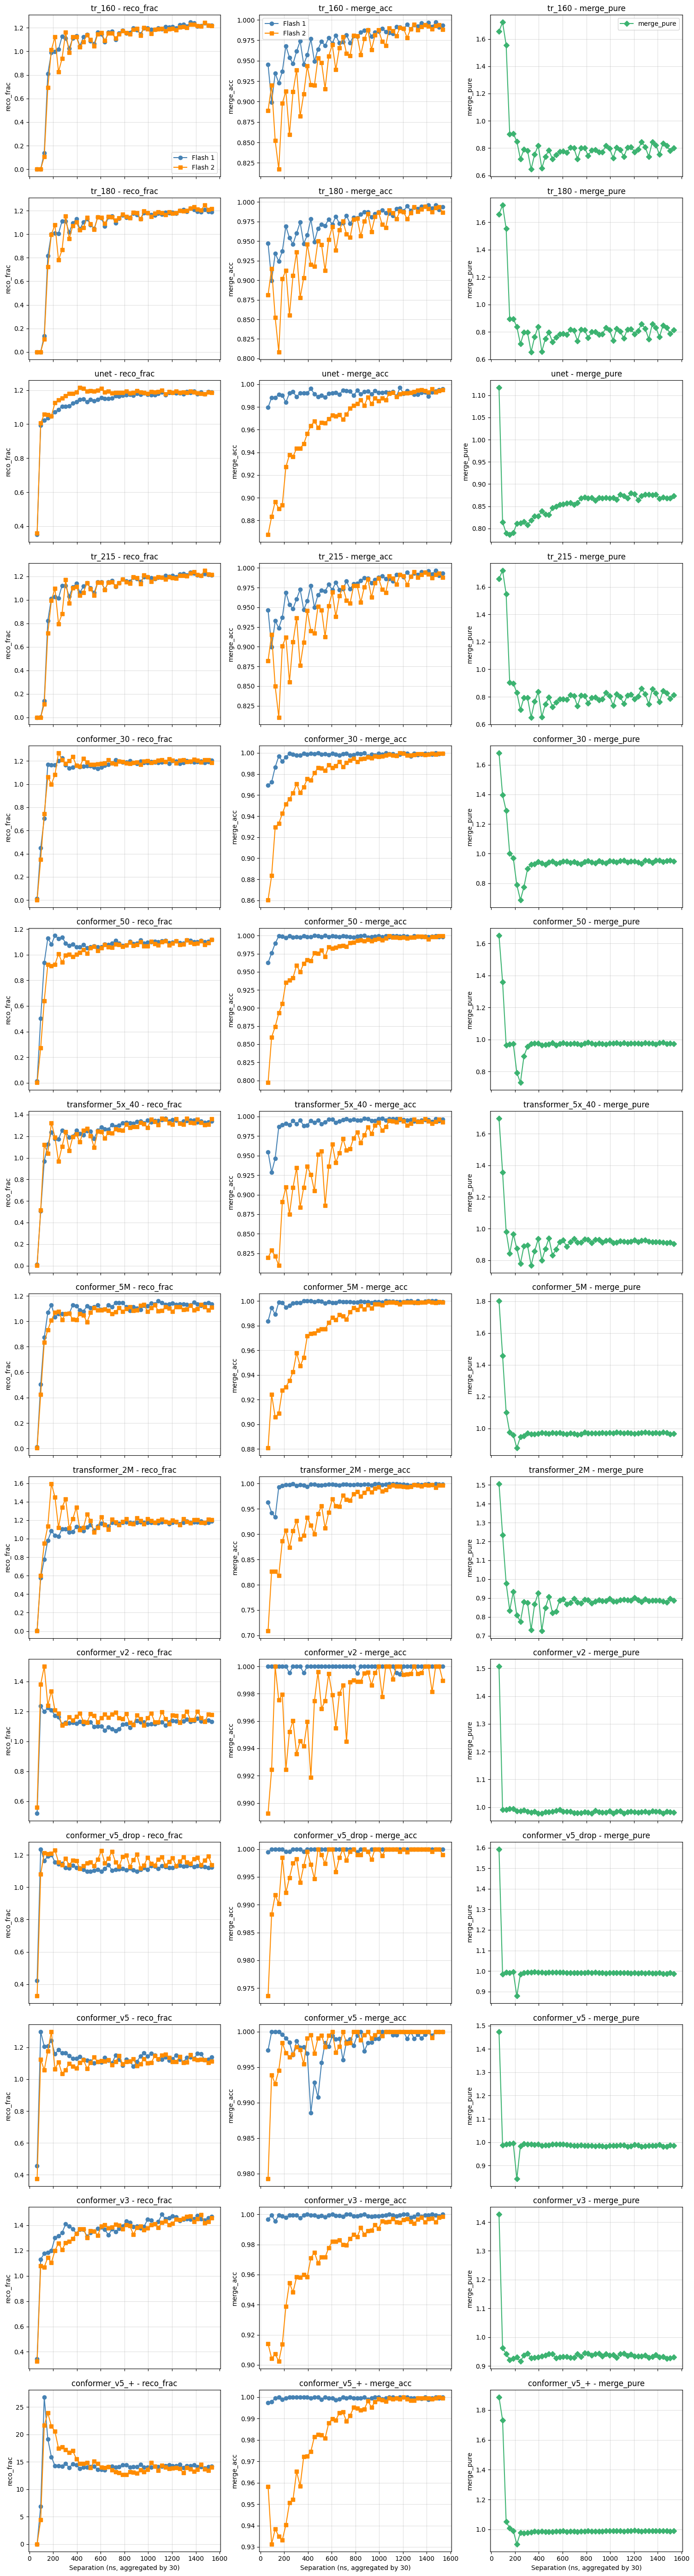

In [24]:
# Aggregate bins (change bin_size=10 for 10 ns bins, etc.)
bin_size = 30
all_delta_results = aggregate_bins(all_delta_results, bin_size=bin_size)
models = all_delta_results.keys()

paired_metrics = {
    "reco_frac": ("reco_frac_flash1", "reco_frac_flash2"),
    "merge_acc": ("merge_acc_flash1", "merge_acc_flash2"),
}
single_metrics = ["merge_pure"]

ncols = len(paired_metrics) + len(single_metrics)
nrows = len(models)

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharex=True)

if nrows == 1:
    axes = np.expand_dims(axes, 0)

colors = ["steelblue", "darkorange"]

for row, model in enumerate(models):
    print(model)
    results = all_delta_results[model]
    print(results.keys())
    bin_centers = results['bin_centers'] + 50

    # ---- Paired metrics ----
    for col, (metric_name, (flash1_key, flash2_key)) in enumerate(paired_metrics.items()):
        ax = axes[row, col]
        ax.plot(bin_centers, results[flash1_key], label=f"Flash 1", color=colors[0], marker="o")
        ax.plot(bin_centers, results[flash2_key], label=f"Flash 2", color=colors[1], marker="s")

        ax.set_title(f"{model} - {metric_name}")
        ax.set_ylabel(metric_name)
        ax.grid(True, alpha=0.4)

        if row == nrows - 1:
            ax.set_xlabel(f"Separation (ns, aggregated by {bin_size})")
        if row == 0:
            ax.legend()

    # ---- Single metrics ----
    for j, metric_name in enumerate(single_metrics):
        col = len(paired_metrics) + j
        ax = axes[row, col]
        ax.plot(bin_centers, results[metric_name], label=metric_name, color="mediumseagreen", marker="D")

        ax.set_title(f"{model} - {metric_name}")
        ax.set_ylabel(metric_name)
        ax.grid(True, alpha=0.4)

        if row == nrows - 1:
            ax.set_xlabel(f"Separation (ns, aggregated by {bin_size})")
        if row == 0:
            ax.legend()

plt.tight_layout()
plt.show()

['unet', 'transformer_2M', 'conformer_5M', 'conformer_v2']


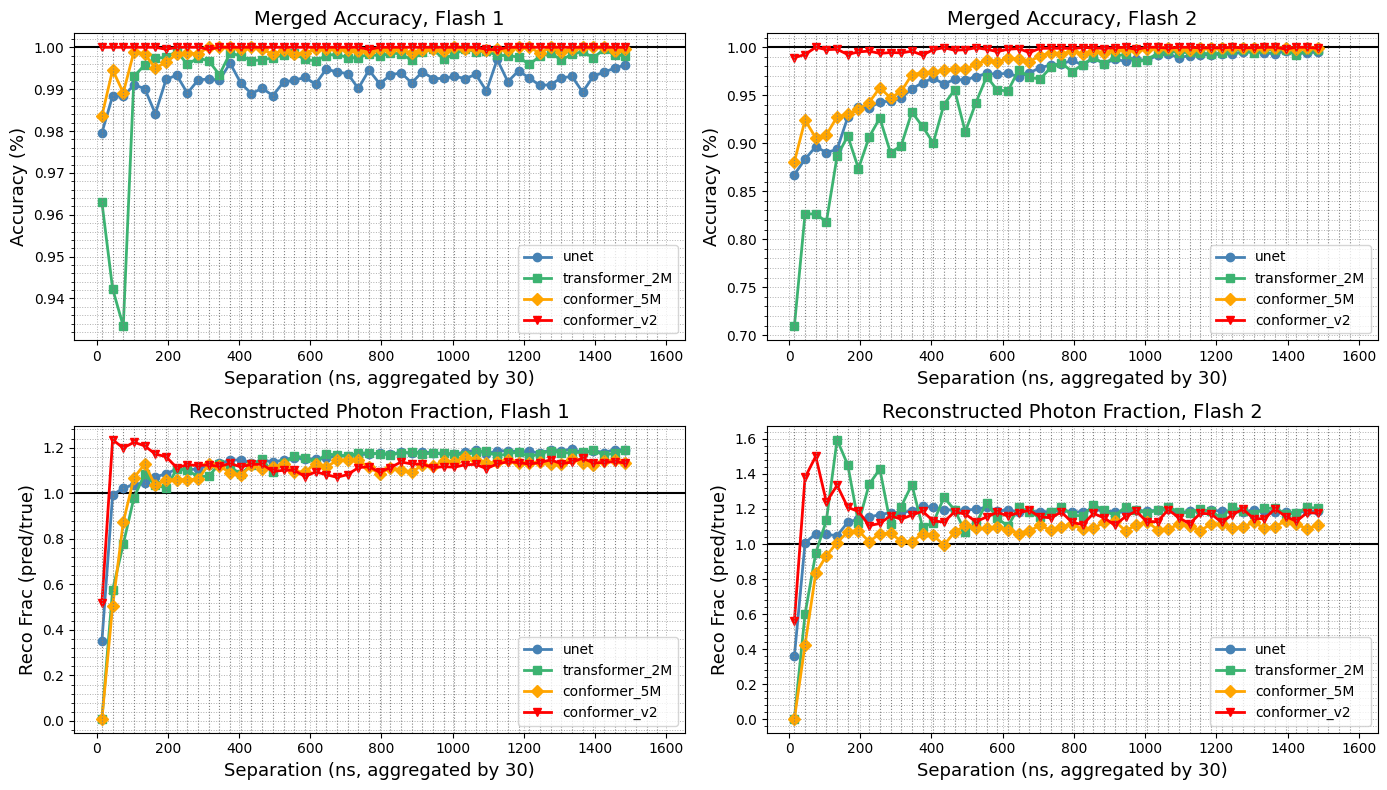

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
model_names = ['unet', 'transformer_2M', 'conformer_5M', 'conformer_v2']
fig, axes = plt.subplots(2, 2, figsize=(14, 8))  # 2 rows, 2 cols
axes = axes.ravel()  # flatten into 1D array for easy indexing
# colors = ["steelblue", "mediumseagreen", "orange", "red", "purple", "pink", "darkslategrey", "darkblue", "gray"]
colors = ["steelblue", "mediumseagreen", "orange", "red", "red", "pink", "darkslategrey", "darkblue", "gray"]
markers = ["o", "s", "D", "v", "^", "o", "s", "o", "D"]
print(model_names)
# --- Top left: Accuracy Flash 1 ---
ax = axes[0]
ax.axhline(y=1, color='black', linestyle='-', linewidth=1.5)
for i, model in enumerate(model_names):
    color = colors[i]
    ax.plot(bin_centers-50, all_delta_results[model]['merge_acc_flash1'],
            marker=markers[i], markersize=6, color=color, label=model, linewidth=2)
ax.legend()
xmin, xmax = ax.get_xlim()
for x in range(15, int(xmax) + 30, 30):
    ax.axvline(x, color="gray", linestyle=":", linewidth=0.8)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="both", which="both", linestyle=":", linewidth=0.7)
ax.set_title("Merged Accuracy, Flash 1", fontsize=14)
ax.set_xlabel("Separation (ns, aggregated by 30)", fontsize=13)
ax.set_ylabel("Accuracy (%)", fontsize=13)

# --- Top right: Accuracy Flash 2 ---
ax = axes[1]
ax.axhline(y=1, color='black', linestyle='-', linewidth=1.5)
for i, model in enumerate(model_names):
    color = colors[i]
    ax.plot(bin_centers-50, all_delta_results[model]['merge_acc_flash2'],
            marker=markers[i], markersize=6, color=color, label=model, linewidth=2)
ax.legend()
xmin, xmax = ax.get_xlim()
for x in range(15, int(xmax) + 30, 30):
    ax.axvline(x, color="gray", linestyle=":", linewidth=0.8)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="both", which="both", linestyle=":", linewidth=0.7)
ax.set_title("Merged Accuracy, Flash 2", fontsize=14)
ax.set_xlabel("Separation (ns, aggregated by 30)", fontsize=13)
ax.set_ylabel("Accuracy (%)", fontsize=13)

# --- Bottom left: Reco Fraction Flash 1 ---
ax = axes[2]
ax.axhline(y=1, color='black', linestyle='-', linewidth=1.5)
for i, model in enumerate(model_names):
    color = colors[i]
    ax.plot(bin_centers-50, all_delta_results[model]['reco_frac_flash1'],
            marker=markers[i], markersize=6, color=color, label=model, linewidth=2)
ax.legend()
xmin, xmax = ax.get_xlim()
for x in range(15, int(xmax) + 30, 30):
    ax.axvline(x, color="gray", linestyle=":", linewidth=0.8)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="both", which="both", linestyle=":", linewidth=0.7)
ax.set_title("Reconstructed Photon Fraction, Flash 1", fontsize=14)
ax.set_xlabel("Separation (ns, aggregated by 30)", fontsize=13)
ax.set_ylabel("Reco Frac (pred/true)", fontsize=13)

# --- Bottom right: Reco Fraction Flash 2 ---
ax = axes[3]
ax.axhline(y=1, color='black', linestyle='-', linewidth=1.5)
for i, model in enumerate(model_names):
    color = colors[i]
    ax.plot(bin_centers-50, all_delta_results[model]['reco_frac_flash2'],
            marker=markers[i], markersize=6, color=color, label=model, linewidth=2)
ax.legend()
xmin, xmax = ax.get_xlim()
for x in range(15, int(xmax) + 30, 30):
    ax.axvline(x, color="gray", linestyle=":", linewidth=0.8)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="both", which="both", linestyle=":", linewidth=0.7)
ax.set_title("Reconstructed Photon Fraction, Flash 2", fontsize=14)
ax.set_xlabel("Separation (ns, aggregated by 30)", fontsize=13)
ax.set_ylabel("Reco Frac (pred/true)", fontsize=13)

# Layout
plt.tight_layout()
plt.show()

['unet', 'transformer_2M', 'conformer_5M', 'conformer_v5_drop']


Text(0, 0.5, 'Purity')

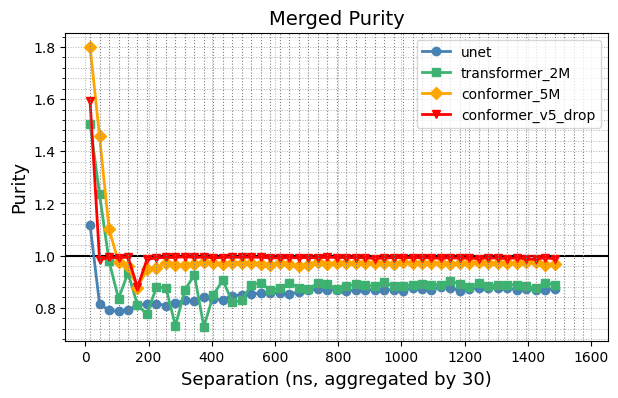

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))  # 2 rows, 2 cols
colors = ["steelblue", "mediumseagreen", "orange", "red", "purple", "pink", "darkslategrey", "darkblue", "gray"]
markers = ["o", "s", "D", "v", "^", "o", "s", "o", "D"]
print(model_names)
ax = axes
# --- Top left: Accuracy Flash 1 ---
ax.axhline(y=1, color='black', linestyle='-', linewidth=1.5)
for i, model in enumerate(model_names):
    color = colors[i]
    ax.plot(bin_centers-50, all_delta_results[model]['merge_pure'],
            marker=markers[i], markersize=6, color=color, label=model, linewidth=2)
xmin, xmax = ax.get_xlim()
for x in range(15, int(xmax) + 30, 30):
    ax.axvline(x, color="gray", linestyle=":", linewidth=0.8)
ax.legend()
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="both", which="both", linestyle=":", linewidth=0.7)
ax.set_title("Merged Purity", fontsize=14)
ax.set_xlabel("Separation (ns, aggregated by 30)", fontsize=13)
ax.set_ylabel("Purity", fontsize=13)

In [27]:
print(all_delta_results['conformer_v2']['merge_pure'])

[1.5070909  0.9912875  0.9919267  0.9940469  0.99399626 0.9861829
 0.9855747  0.9890288  0.983872   0.9813884  0.9843599  0.97817504
 0.97856444 0.9824781  0.98284    0.9841481  0.9875477  0.99108225
 0.98392254 0.9848929  0.98477286 0.98013383 0.97890097 0.9803435
 0.9831179  0.9809641  0.9783472  0.9877778  0.98273087 0.98091424
 0.98161066 0.9861791  0.9787897  0.98405415 0.98575664 0.9779141
 0.98252827 0.98537666 0.98305017 0.9810044  0.9838084  0.98444515
 0.9808784  0.9869947  0.98473656 0.9839684  0.97818    0.9849508
 0.9832713  0.981308  ]


In [32]:
print(1500/30)
print(len(all_delta_results['conformer_v2']['merge_acc_flash1']))
print(bin_centers - 50)

50.0
50
[  15.   45.   75.  105.  135.  165.  195.  225.  255.  285.  315.  345.
  375.  405.  435.  465.  495.  525.  555.  585.  615.  645.  675.  705.
  735.  765.  795.  825.  855.  885.  915.  945.  975. 1005. 1035. 1065.
 1095. 1125. 1155. 1185. 1215. 1245. 1275. 1305. 1335. 1365. 1395. 1425.
 1455. 1485.]


In [7]:
# --- Load the YAML config ---
import yaml
with open("model_list.yaml", "r") as f:
    config = yaml.safe_load(f)

# --- Dictionary to hold results ---
single_flash_results = {}

# --- Iterate over models in YAML ---
for model_name, model_info in config.items():
    if not model_info.get("include", False):
        continue  # skip models not marked for use

    pstats_path = model_info.get("single_flash_pstats")
    if not pstats_path:
        print(f"⚠️ No single_flash_pstats for {model_name}, skipping.")
        continue

    try:
        stats = np.load(pstats_path, allow_pickle=True).item()
        single_flash_results[model_name] = stats
        print(f"✅ Loaded results for {model_name} from {pstats_path}")
    except Exception as e:
        print(f"❌ Could not load stats for {model_name}: {e}")

# --- Merge into one flat dict like {**dict1, **dict2, ...} ---
all_results = {}
for stats in single_flash_results.values():
    all_results.update(stats)

✅ Loaded results for conformer_v3 from performance_analysis/conv3_single_flash_results.npy


(990,)


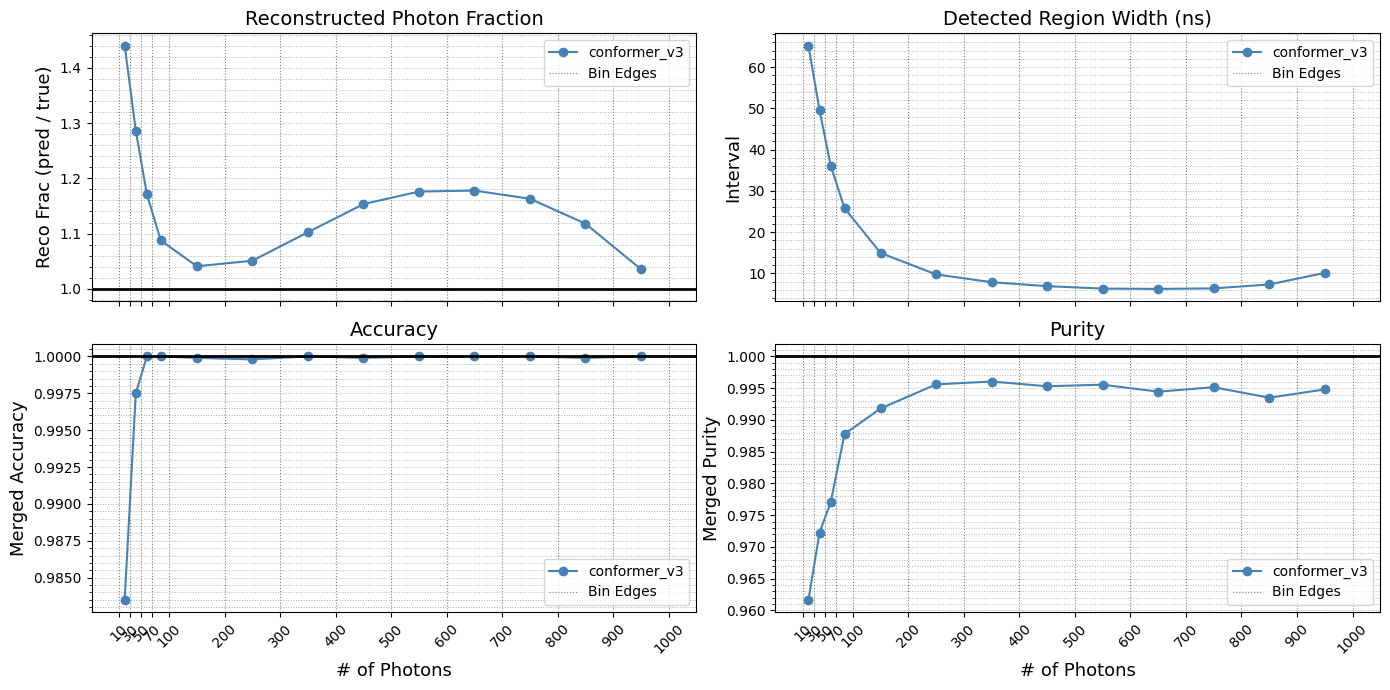

In [9]:
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator

colors = ["steelblue", "mediumseagreen", "orange", "red", "purple"]
markers = ["o", "s", "D", "v", "^"]
model_names = list(all_results.keys())
# model_names.remove('conformer_30')
# model_names.remove('transformer_5x_40')
# model_names.remove('tr_160')
# model_names.remove('tr_215')
# model_names = ['unet', 'conformer_5M', 'transformer_2M', 'conformer_mlp']
#['conformer_5M', 'transformer_2M', 'conformer_30', 'conformer_50', 'transformer_5x_40', 'conformer_mlp', 'conformer_v2', 'conformer_v5_drop', 'conformer_v5', 'tr_160', 'tr_215', 'unet']

# Convert each model's data into arrays
model_reco_frac = {name: np.array(all_results[name]["reco_frac"]) for name in model_names}
model_interval = {name: np.array(all_results[name]["interval"]) for name in model_names}
model_acc = {name: np.array(all_results[name]["merge_acc"]) for name in model_names}
model_pure = {name: np.array(all_results[name]["merge_pure"]) for name in model_names}

# Define binning
bin_size = 100
ref_data = next(iter(model_reco_frac.values()))  # reference length
print(ref_data.shape)
bin_sizes = [20, 20, 20, 30] + [bin_size] * (len(ref_data) // bin_size)
bin_edges = np.cumsum([10] + bin_sizes)
bin_centers = bin_edges[:-1] + (np.array(bin_sizes) / 2)

def bin_data(arr, bin_sizes):
    """Average data into bins of variable width."""
    out, start = [], 0
    for b in bin_sizes:
        out.append(arr[start:start+b].mean())
        start += b
    return np.array(out)

# Create 1x2 plot
fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True)
axes = axes.flatten()
# -------- Plot reco_frac --------
ax = axes[0]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_reco_frac[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker)

# Bin edges
for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)
# ax.set_xlabel("# of Photons")
ax.axhline(1, color="black", linestyle="-", linewidth=2)
ax.set_ylabel("Reco Frac (pred / true)", fontsize=13)
ax.set_title("Reconstructed Photon Fraction", fontsize=14)
ax.set_xticks(bin_edges)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
# ax.grid(axis="y")
ax.legend()

# -------- Plot interval --------
ax = axes[1]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_interval[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker)

for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)

# ax.set_xlabel("# of Photons")
ax.set_ylabel("Interval", fontsize=13)
ax.set_title("Detected Region Width (ns)", fontsize=14)
ax.set_xticks(bin_edges)
# ax.set_xticklabels(bin_edges, rotation=45)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
ax.legend()

# -------- Plot Accuracy --------
ax = axes[2]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_acc[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker)

for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)
ax.axhline(1, color="black", linestyle="-", linewidth=2)
ax.set_xlabel("# of Photons", fontsize=13)
ax.set_ylabel("Merged Accuracy", fontsize=13)
ax.set_title("Accuracy", fontsize=14)
ax.set_xticks(bin_edges)
ax.set_xticklabels(bin_edges, rotation=45)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
ax.legend()

# -------- Plot Purity --------
ax = axes[3]
for idx, name in enumerate(model_names):
    color = colors[idx % len(colors)]
    marker = markers[idx % len(markers)]
    binned = bin_data(model_pure[name], bin_sizes)
    ax.plot(bin_centers, binned, label=name, color=color, marker=marker)

for i, edge in enumerate(bin_edges):
    ax.axvline(edge, color="gray", linestyle=":", linewidth=0.8,
               label="Bin Edges" if i == 0 else None)
ax.axhline(1, color="black", linestyle="-", linewidth=2)
ax.set_xlabel("# of Photons", fontsize=13)
ax.set_ylabel("Merged Purity", fontsize=13)
ax.set_title("Purity", fontsize=14)
ax.set_xticks(bin_edges)
ax.set_xticklabels(bin_edges, rotation=45)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis="y", which="both", linestyle=":", linewidth=0.7)
ax.legend()

plt.tight_layout()
plt.show()